# Imports

In [2]:
import os
import torch
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch import nn
from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.dataset import Subset
import torchvision.datasets as datasets

from torchvision import datasets
import torchvision.transforms.functional as TF
import torchvision.models.swin_transformer as ST

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import timm
import cv2
import numpy as np

from PIL import Image

import zipfile
import copy
import random
import warnings
warnings.filterwarnings("ignore")

# GPU

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
print(device)

cuda


# Utils

In [3]:
def extract_and_subsample_class(dataset, class_label, fraction):
    indices = np.where(np.array(dataset.targets) == class_label)[0]
    keep_size = int(len(indices) * fraction)
    indices = indices[:keep_size]
    dataset.data = dataset.data[indices]
    dataset.targets = np.array(dataset.targets)[indices].tolist()
    return dataset


def mask_image(sample_image, miss_size):
    masked_img = copy.deepcopy(sample_image)
    masked_img[:, :, :miss_size] = 0
    return masked_img

class MaskImage(object):
    def __init__(self, miss_size):
        self.miss_size = miss_size

    def __call__(self, sample):
        transformed_image = mask_image(sample, self.miss_size)
        return transformed_image

class CSI_Simulated(object):
    def __init__(self, miss_size):
        self.miss_size = miss_size

    def __call__(self, sample):
        diff = (sample - mask_image(sample, self.miss_size))[:, :32, :10]
        return diff
    
    
def random_shuffle(len):
  indices = list(range(len))
  random.shuffle(indices)

  return indices

def non_random_split(dataset, lengths, indices):
    assert sum(lengths) == len(dataset), "The sum of the subset lengths should equal the length of the dataset."

    subsets = []

    start = 0
    for length in lengths:
        subset_indices = indices[start:start+length]
        subsets.append(Subset(dataset, subset_indices))
        start += length

    return subsets

# Datasets

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download = True, transform = transform)

class_label = 5 # dog class
fraction = 1
trainset = extract_and_subsample_class(trainset, class_label, fraction)
testset = extract_and_subsample_class(testset, class_label, fraction)

masked_transform = transforms.Compose([
    transforms.ToTensor(),
    MaskImage(miss_size=10)
])

masked_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=masked_transform)
masked_testset = datasets.CIFAR10(root='./data', train=False, download = True, transform = masked_transform)
masked_trainset = extract_and_subsample_class(masked_trainset, class_label, fraction)
masked_testset = extract_and_subsample_class(masked_testset, class_label, fraction)

csi_transform = transforms.Compose([
    transforms.ToTensor(),
    CSI_Simulated(miss_size=10)
])

csi_simulated_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=csi_transform)
csi_simulated_testset = datasets.CIFAR10(root='./data', train=False, download = True, transform = csi_transform)
csi_simulated_trainset = extract_and_subsample_class(csi_simulated_trainset, class_label, fraction)
csi_simulated_testset = extract_and_subsample_class(csi_simulated_testset, class_label, fraction)

size = trainset.__len__()
test_size = testset.__len__()
print(f"\nActual dataset size: {size}")
print(f"\nActual test size: {test_size}")

train_size = int(0.9*size)
val_size = int(0.1*size)

indices = random_shuffle(size)
train_subsets = non_random_split(trainset, [train_size, val_size], indices)
masked_subsets = non_random_split(masked_trainset, [train_size, val_size], indices)
csi_simulated_subsets = non_random_split(csi_simulated_trainset, [train_size, val_size], indices)

train_set = train_subsets[0]
val_set = train_subsets[1]
masked_train_set = masked_subsets[0]
masked_val_set = masked_subsets[1]
csi_simulated_train_set = csi_simulated_subsets[0]
csi_simulated_val_set = csi_simulated_subsets[1]

print("\nAfter splitting: \n")
print(f"Training size: {train_size}")
print(f"Validation size: {val_size}")
print(f"Test size: {test_size}")


100%|██████████| 170498071/170498071 [00:08<00:00, 20140244.28it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified

Actual dataset size: 5000

Actual test size: 1000

After splitting: 

Training size: 4500
Validation size: 500
Test size: 1000


# Samples

In [5]:
batch_size = 16

Dimension of Train Batch is 16
Dimension of Validation Batch is 16
Dimension of Test Batch is 16
Image size: torch.Size([3, 32, 32])


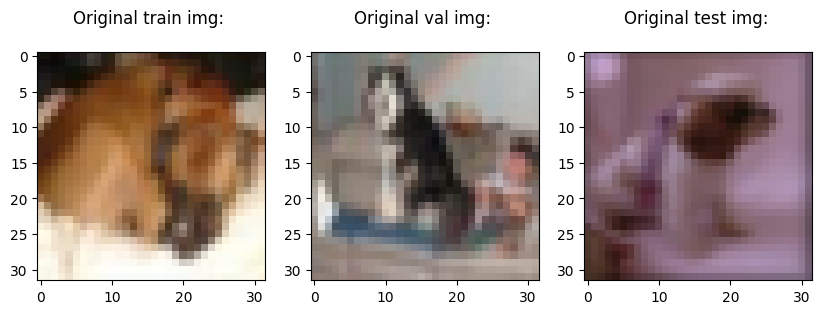

Dimension of Masked Train Batch is 16
Dimension of Masked Validation Batch is 16
Dimension of Masked Test Batch is 16
Image size: torch.Size([3, 32, 32])


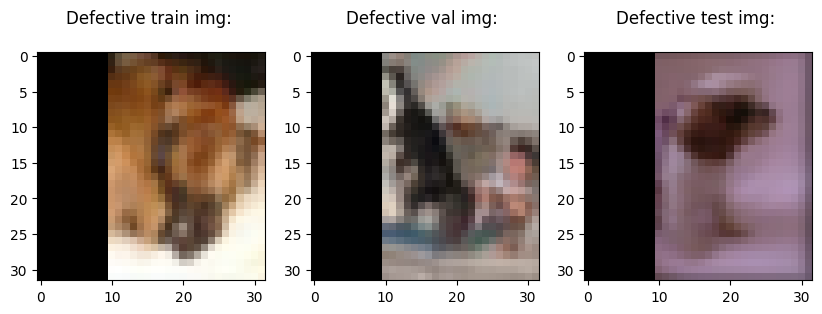

Dimension of CSI Simulated Train Batch is 16
Dimension of CSI Simulated Validation Batch is 16
Dimension of CSI Simulated Test Batch is 16
Image size: torch.Size([3, 32, 10])


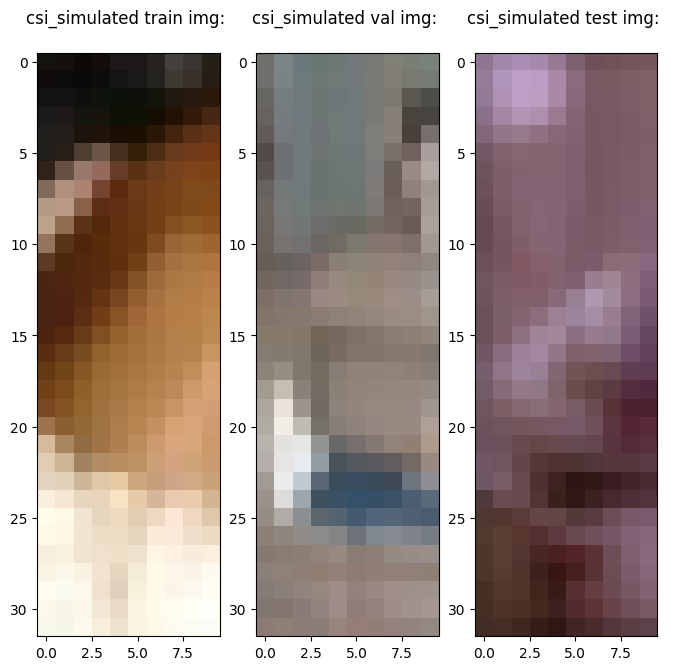

In [6]:
# groundthruth_* contains original images
groundthruth_trainloader = DataLoader(train_set, batch_size= batch_size, shuffle=False)
groundthruth_valloader = DataLoader(val_set, batch_size = batch_size)
groundthruth_testloader = DataLoader(testset, batch_size = batch_size)

# masked_* contains defective (masked) images
masked_trainloader = DataLoader(masked_train_set, batch_size= batch_size, shuffle=False)
masked_valloader = DataLoader(masked_val_set, batch_size = batch_size)
masked_testloader = DataLoader(masked_testset, batch_size = batch_size)

# csi_* contains csi (simulation) images
csi_trainloader = DataLoader(csi_simulated_train_set, batch_size= batch_size, shuffle=False)
csi_valloader = DataLoader(csi_simulated_val_set, batch_size = batch_size)
csi_testloader = DataLoader(csi_simulated_testset, batch_size = batch_size)


groundthruth_train_batch = next(iter(groundthruth_trainloader))
#print('Dimension of Train Batch is ' + str(len(groundthruth_train_batch[0])))
groundthruth_val_batch = next(iter(groundthruth_valloader))
#print('Dimension of Validation Batch is ' + str(len(groundthruth_val_batch[0])))
groundthruth_test_batch = next(iter(groundthruth_testloader))
#print('Dimension of Test Batch is ' + str(len(groundthruth_test_batch[0])))

groundthruth_train_batch = next(iter(groundthruth_trainloader))
print('Dimension of Train Batch is ' + str(len(groundthruth_train_batch[0])))
groundthruth_val_batch = next(iter(groundthruth_valloader))
print('Dimension of Validation Batch is ' + str(len(groundthruth_val_batch[0])))
groundthruth_test_batch = next(iter(groundthruth_testloader))
print('Dimension of Test Batch is ' + str(len(groundthruth_test_batch[0])))

rnd_idx = random.randint(0, batch_size-1)

train_image = groundthruth_train_batch[0][rnd_idx]
val_image = groundthruth_val_batch[0][rnd_idx]
test_image = groundthruth_test_batch[0][rnd_idx]

print(f"Image size: {train_image.shape}")

plt.rcParams["figure.figsize"] = (10, 10)

plt.subplot(1,3,1)
plt.imshow(train_image.permute(1,2,0))
plt.title("Original train img: \n")

plt.subplot(1,3,2)
plt.imshow(val_image.permute(1,2,0))
plt.title("Original val img: \n")

plt.subplot(1,3,3)
plt.imshow(test_image.permute(1,2,0))
plt.title("Original test img: \n")
plt.show()

masked_train_batch = next(iter(masked_trainloader))
print('Dimension of Masked Train Batch is ' + str(len(masked_train_batch[0])))
masked_val_batch = next(iter(masked_valloader))
print('Dimension of Masked Validation Batch is ' + str(len(masked_val_batch[0])))
masked_test_batch = next(iter(masked_testloader))
print('Dimension of Masked Test Batch is ' + str(len(masked_test_batch[0])))

masked_train_image = masked_train_batch[0][rnd_idx]
masked_val_image = masked_val_batch[0][rnd_idx]
masked_test_image = masked_test_batch[0][rnd_idx]

print(f"Image size: {masked_train_image.shape}")

plt.rcParams["figure.figsize"] = (10, 10)

plt.subplot(1,3,1)
plt.imshow(masked_train_image.permute(1,2,0))
plt.title("Defective train img: \n")

plt.subplot(1,3,2)
plt.imshow(masked_val_image.permute(1,2,0))
plt.title("Defective val img: \n")

plt.subplot(1,3,3)
plt.imshow(masked_test_image.permute(1,2,0))
plt.title("Defective test img: \n")
plt.show()

csi_simulated_train_batch = next(iter(csi_trainloader))
print('Dimension of CSI Simulated Train Batch is ' + str(len(csi_simulated_train_batch[0])))
csi_simulated_val_batch = next(iter(csi_valloader))
print('Dimension of CSI Simulated Validation Batch is ' + str(len(csi_simulated_val_batch[0])))
csi_simulated_test_batch = next(iter(csi_testloader))
print('Dimension of CSI Simulated Test Batch is ' + str(len(csi_simulated_test_batch[0])))

csi_simulated_train_image = csi_simulated_train_batch[0][rnd_idx]
csi_simulated_val_image = csi_simulated_val_batch[0][rnd_idx]
csi_simulated_test_image = csi_simulated_test_batch[0][rnd_idx]

print(f"Image size: {csi_simulated_train_image.shape}")

plt.rcParams["figure.figsize"] = (8, 8)

plt.subplot(1,3,1)
plt.imshow(csi_simulated_train_image.permute(1,2,0), cmap='gray')
plt.title("csi_simulated train img: \n")

plt.subplot(1,3,2)
plt.imshow(csi_simulated_val_image.permute(1,2,0), cmap='gray')
plt.title("csi_simulated val img: \n")

plt.subplot(1,3,3)
plt.imshow(csi_simulated_test_image.permute(1,2,0), cmap='gray')
plt.title("csi_simulated test img: \n")
plt.show()

# Hyperparameters

In [7]:
# hyperparameters

# patch encoders parameters
projection_dim = 256
csi_dim = (batch_size, 3, 32, 10)
mask_dim = (batch_size, 3, 32, 32)
img_dim = (batch_size, 3, 32, 32)


# encoding layer CSI parameters
num_heads = 2
transformer_layers = 8
hidden_units = [512, 16*3*32*256]                       
normalized_shape = (32, 256)        
in_features = 16*3*32*256            
key_dim = 256 

# encoding layer IMG parameters
M = 3
lin_emb_dim = 256


# aggregation layer parameters

out1 = 2048
out2 = 1024
out3 = 784
reshape_size = (1, 28, 28)
resize_size = (3, 28, 28)

# Architecture

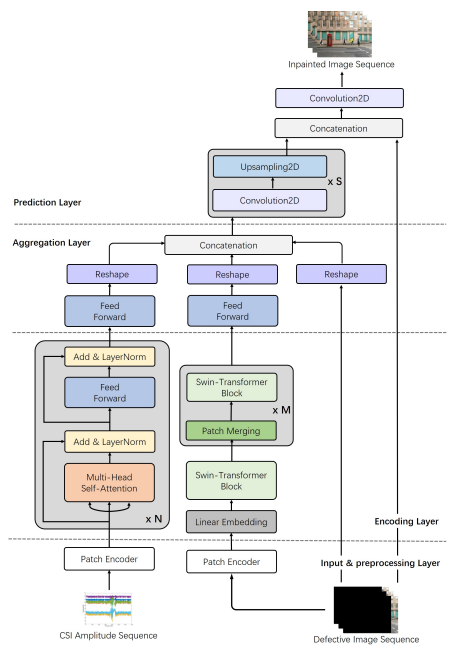

# Patch Encoder (CSI)

In [8]:
class Patch_Encoder_CSI(nn.Module):
    def __init__(self):
        super(Patch_Encoder_CSI, self).__init__()
        self.Dense = nn.Linear(csi_dim[3], projection_dim)
    
    def forward(self, x):
        x = self.Dense(x)
        return x

# Encoding Layer (CSI)

In [9]:
class MultiHeadAttentionLayer(nn.Module):
  def __init__(self, num_heads, key_dim, dropout=0.1):
    super(MultiHeadAttentionLayer, self).__init__()
    self.num_heads = num_heads
    self.key_dim = key_dim
    self.dropout = dropout
    self.attention = nn.MultiheadAttention(embed_dim= key_dim, num_heads=num_heads, dropout=dropout)

  def forward(self, query, key, value): # to check
    query = query.permute(2, 0, 1, 3).reshape(32, -1, 256)
    key = key.permute(2, 0, 1, 3).reshape(32, -1, 256)
    value = value.permute(2, 0, 1, 3).reshape(32, -1, 256)
    attention_output, _ = self.attention(query, key, value)
    att = attention_output.view(16,3,32,256)
    
    return att

class AddENormLayer(nn.Module):
  def __init__(self, normalized_shape):
    super(AddENormLayer, self).__init__()
    self.Normalization = nn.LayerNorm(normalized_shape = normalized_shape, eps = 1e-6)

  def forward(self, x1, x2):
    y = x1+x2
    return  self.Normalization(y)

class FeedForwardLayer1(nn.Module):
    def __init__(self, in_features, hidden_units):
        super(FeedForwardLayer1, self).__init__()
        self.in_features = in_features
        self.hidden_units = hidden_units
        self.Linear1 = nn.Linear(self.in_features, self.hidden_units[0])
        self.Linear2 = nn.Linear(self.hidden_units[0], self.hidden_units[1])
        self.Dropout = nn.Dropout(p=0.1)
        self.Gelu = nn.GELU()

    def forward(self, x):
        x = x.view(-1)
        x = self.Linear1(x)
        x = self.Gelu(x)
        x = self.Dropout(x) 
        x = self.Linear2(x)
        x = self.Gelu(x)
        x = self.Dropout(x)
        x = x.view(16, 3, 32, 256)
        return x

class EncodingLayer_CSI(nn.Module):
    def __init__(self, num_heads, normalized_shape, key_dim, in_features, hidden_units, transformer_layers):
        super(EncodingLayer_CSI, self).__init__()
        self.Normalization = nn.LayerNorm(normalized_shape = normalized_shape, eps = 1e-6)
        self.MultiHeadAttention = MultiHeadAttentionLayer(num_heads=num_heads, key_dim=key_dim, dropout=0.1)
        self.AddENorm = AddENormLayer(normalized_shape)
        self.FeedForward = FeedForwardLayer1(in_features, hidden_units)

    def forward(self, patch_encoded_csi):
        for i in range(transformer_layers):
            x0 = self.Normalization(patch_encoded_csi)
            x1 = self.MultiHeadAttention(x0,x0,x0)
            x2 = self.AddENorm(x0, x1)
            x3 = self.FeedForward(x2)
            x4 = self.AddENorm(x2, x3)

        return x4



# Patch Encoder (Mask)

In [10]:
class Patch_Encoder_Mask(nn.Module):
    def __init__(self):
        super(Patch_Encoder_Mask, self).__init__()
        self.Dense = nn.Linear(mask_dim[3], projection_dim)
    
    def forward(self, x):
        x = self.Dense(x)
        return x

# Encoding Layer (Mask)

In [11]:
class SwinTransformerBlock(nn.Module):
    def __init__(self):
        super(SwinTransformerBlock, self).__init__()
        HUB_URL = "SharanSMenon/swin-transformer-hub:main"
        MODEL_NAME = "swin_tiny_patch4_window7_224"
        self.swin_transformer = torch.hub.load(HUB_URL, MODEL_NAME, pretrained=True) # load from torch hub
    
    def forward(self,x):
        x = F.interpolate(x, size=(224,224), mode='bilinear', align_corners=False)
        x = self.swin_transformer(x)
        return x

class DenseLayer(nn.Module):

  def __init__(self):
    super(DenseLayer, self).__init__()
    self.Linear = nn.Linear(1000, 784)

  def forward(self,x):
    x = self.Linear(x)
    return x


class EncodingLayer_Mask(nn.Module):
    def __init__(self):
        super(EncodingLayer_Mask, self).__init__()
        self.swin = SwinTransformerBlock()
        self.dense = DenseLayer()
    
    def forward(self, x):
        x = self.swin.forward(x)
        x = self.dense.forward(x)
        return x

# Aggregation Layer 


In [13]:
class FlattenLayer(nn.Module):
  def forward(self, x):
    return x.view(batch_size, -1)

class FeedForwardLayer2(nn.Module):
    def __init__(self):
        super(FeedForwardLayer2, self).__init__()
        self.batch_norm = nn.LayerNorm(normalized_shape = (batch_size, 24576), eps = 1e-6)
        self.fc1 = nn.Linear(24576, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 784)

    def forward(self, x):
        x = self.batch_norm(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        output = x.view(-1, 1, 28, 28)
        return output
    
class ReshapeLayer(nn.Module):

  def __init__(self):
    super(ReshapeLayer, self).__init__()
    self.size = (1,28,28)

  def forward(self, x):
    x = x.view(batch_size, self.size[0], self.size[1], self.size[2])
    return x

class ResizeLayer(nn.Module):

  def __init__(self):
    super(ResizeLayer, self).__init__()
    self.size = (28,28)

  def forward(self, x):
    transform = transforms.Compose([
        transforms.Resize(self.size),
    ])
    resized_image = transform(x)
    return resized_image
    
class ConcatenationLayer(nn.Module):
    
    def __init__(self):
        super(ConcatenationLayer, self).__init__()
        
    def forward(self, x1, x2, x3):
        x = torch.cat((x1, x2, x3), dim=1)
        return x

class AggregationLayer(nn.Module):
    def __init__(self):
        super(AggregationLayer, self).__init__()
        self.Flatten = FlattenLayer()
        self.Dropout = nn.Dropout(p=0.5)
        self.FeedForward2 = FeedForwardLayer2() 
        self.Reshape = ReshapeLayer()
        self.Resize = ResizeLayer()
        self.Concatenation = ConcatenationLayer()
        
    def forward(self, encoded_csi, encoded_mask, mask):
        x1 = self.Flatten.forward(encoded_csi)
        x1 = self.Dropout.forward(x1)
        x1 = self.FeedForward2.forward(x1)
        
        x2 = self.Reshape.forward(encoded_mask)
        
        x3 = self.Resize.forward(mask)
        x = self.Concatenation(x1,x2,x3)
        
        return x

# Decoder

In [14]:
class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.conv1 = nn.Conv2d(5, 10, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(10, 5, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(5, 3, kernel_size=3, padding=1)
        self.upsample = nn.Upsample(size=(32, 32), mode='bilinear', align_corners=False)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.upsample(x)
        return x

# Model

In [15]:
## Overall: Trans-inpainter

class TransInpainterModel(nn.Module):
    def __init__(self):
        super(TransInpainterModel, self).__init__()
        self.patch_encoder_csi = Patch_Encoder_CSI()
        self.encoder_csi = EncodingLayer_CSI(num_heads, normalized_shape, key_dim, in_features, hidden_units, transformer_layers)
        self.patch_encoder_mask = Patch_Encoder_Mask()
        self.encoder_mask = EncodingLayer_Mask()
        self.aggregation_layer = AggregationLayer()
        self.decoder_layer = DecoderLayer()
        
    def forward(self, csi, mask):
        
        patch_encoded_csi = self.patch_encoder_csi.forward(csi)
        encoded_csi = self.encoder_csi.forward(patch_encoded_csi)
        patch_encoded_mask = self.patch_encoder_mask.forward(mask)
        encoded_mask = self.encoder_mask.forward(patch_encoded_mask)
        aggregation_output = self.aggregation_layer.forward(encoded_csi, encoded_mask, mask) 
        prediction = self.decoder_layer.forward(aggregation_output)
        
        return prediction


In [37]:
model = TransInpainterModel()

Using cache found in /root/.cache/torch/hub/SharanSMenon_swin-transformer-hub_main


# Concatenation of Datasets

In [16]:
class UnifyDataset(Dataset):
    def __init__(self, x1_set, x2_set, y_set):
        self.x1_set = x1_set
        self.x2_set = x2_set
        self.y_set = y_set
        
    def __len__(self):
        return len(self.x1_set)
    
    def __getitem__(self, idx):
        x1 = self.x1_set[idx]
        x2 = self.x2_set[idx]
        y = self.y_set[idx]
        return x1, x2, y
    
    def __next__(self):
        batch = next(self.iterator)
        if len(batch) != self.batch_size and len(batch) < self.batch_size:
            # Skip the last batch if it doesn't match the expected batch size
            raise StopIteration
        return batch

# Creazione del dataset personalizzato
train_dataset = UnifyDataset(csi_simulated_train_set, masked_train_set, train_set)
val_dataset = UnifyDataset(csi_simulated_val_set, masked_val_set, val_set)
test_dataset = UnifyDataset(csi_simulated_testset, masked_testset, testset)

# Creazione del DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# Model Training and Validation

In [17]:
def print_outputs(outputs, predictions, epoch):
  print(f"Epoch {epoch}\n")
  fig, axes = plt.subplots(1, 2)
  axes[0].imshow(outputs[0].cpu().permute(1,2,0))
  axes[0].set_title('Groundthruth')
  axes[0].axis('off')
  axes[1].imshow(predictions[0].cpu().permute(1,2,0).detach().numpy())
  axes[1].set_title('Inpainted')
  axes[1].axis('off')
  #plt.title(f'Epoch {epoch}')
  plt.show()
  print("\n")

  return


In [18]:
def plot_loss(loss, label):
  x = list(range(1, len(loss) + 1))
  plt.figure(figsize=(6, 6))
  plt.plot(x, loss, label=label)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss')
  plt.legend()
  plt.show()
  return

In [19]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss)
            self.counter = 0

    def save_checkpoint(self, val_loss):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        self.val_loss_min = val_loss


Downloading: "https://github.com/SharanSMenon/swin-transformer-hub/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_tiny_patch4_window7_224.pth" to /root/.cache/torch/hub/checkpoints/swin_tiny_patch4_window7_224.pth
100%|██████████| 109M/109M [00:00<00:00, 286MB/s] 


Started training...

Epoch 0



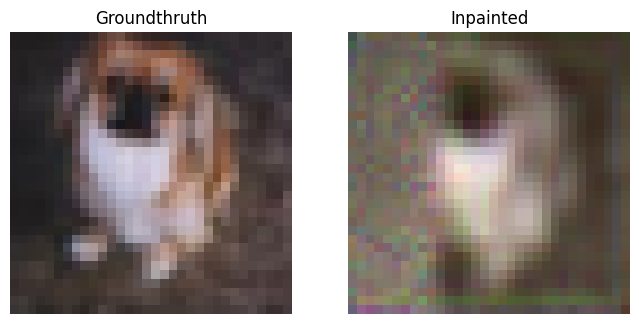



Validation loss decreased (inf --> 0.763366).  Saving model ...
Validation loss decreased (0.763366 --> 0.637586).  Saving model ...
Validation loss decreased (0.637586 --> 0.577013).  Saving model ...
Validation loss decreased (0.577013 --> 0.556291).  Saving model ...
Validation loss decreased (0.556291 --> 0.546084).  Saving model ...
Epoch 5



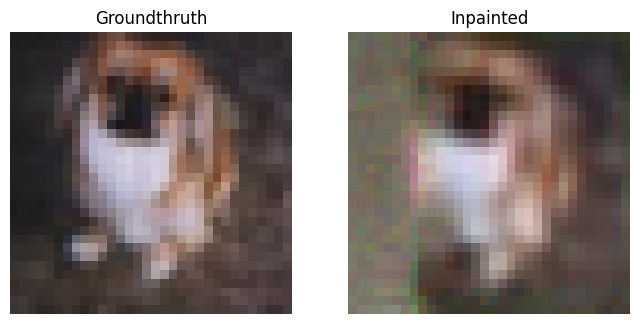



Validation loss decreased (0.546084 --> 0.536251).  Saving model ...
Validation loss decreased (0.536251 --> 0.407365).  Saving model ...
Validation loss decreased (0.407365 --> 0.366439).  Saving model ...
Validation loss decreased (0.366439 --> 0.352699).  Saving model ...
Validation loss decreased (0.352699 --> 0.343278).  Saving model ...
Epoch 10



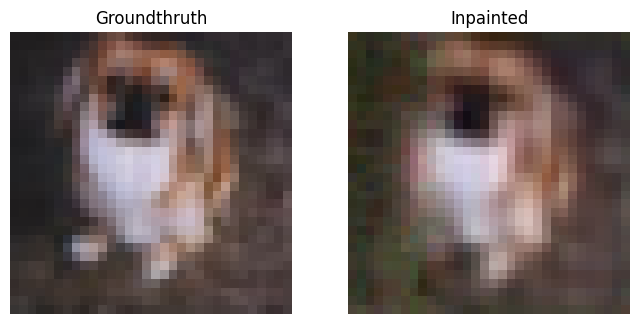



Validation loss decreased (0.343278 --> 0.338767).  Saving model ...
Validation loss decreased (0.338767 --> 0.336642).  Saving model ...
EarlyStopping counter: 1 out of 5
Validation loss decreased (0.336642 --> 0.333140).  Saving model ...
Validation loss decreased (0.333140 --> 0.329842).  Saving model ...
Epoch 15



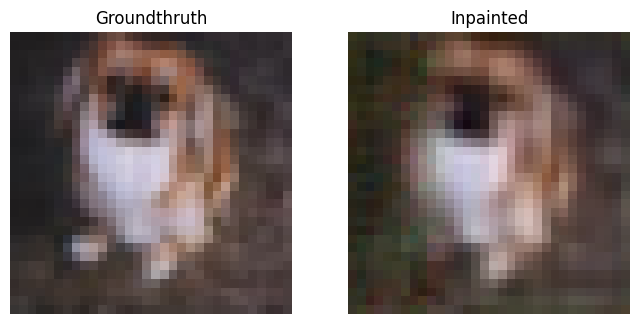



Validation loss decreased (0.329842 --> 0.327914).  Saving model ...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
Epoch 20



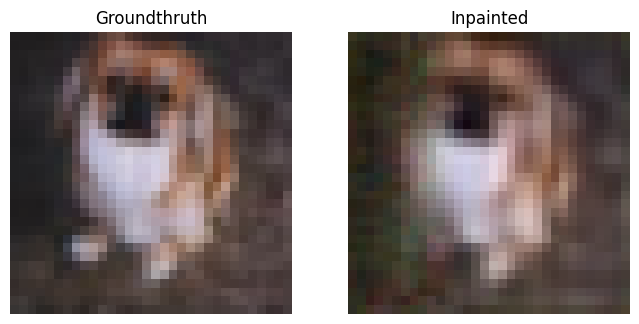



EarlyStopping counter: 5 out of 5
Early stopping


In [20]:
# Model Training and Validation

# Model

model = TransInpainterModel().cuda()

# Loss
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Early Stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

# epochs
epochs = 100  

training_loss = []
val_loss = []
train_batch = train_dataloader.__len__()
val_batch = val_dataloader.__len__()

# with regularization term
print("Started training...\n")

for epoch in range(epochs):
    train_loss_per_epoch = 0
    val_loss_per_epoch = 0
   
    for batch_idx, (csi, masked, outputs) in enumerate(train_dataloader,0): 
        if batch_idx < train_batch-1:
            csi_batch = csi[0].float().to('cuda')
            masked_batch = masked[0].float().to('cuda')
            outputs_batch = outputs[0].float().to('cuda')
            predictions = model(csi_batch, masked_batch)
            optimizer.zero_grad()
            loss = criterion(predictions, outputs_batch)
            loss.backward()
            optimizer.step()
            train_loss_per_epoch += loss.item()
    
    scheduler.step()
    training_loss.append(train_loss_per_epoch)     
    if (epoch%5)==0:
        print_outputs(outputs_batch, predictions, epoch)
    
    model.eval()
    with torch.no_grad():
        for batch_idx, (csi, masked, outputs) in enumerate(val_dataloader,0): 
            if batch_idx < val_batch-1:
                csi_batch = csi[0].float().to('cuda')
                masked_batch = masked[0].float().to('cuda')
                outputs_batch = outputs[0].float().to('cuda')
                predictions = model(csi_batch, masked_batch)
                loss = criterion(predictions, outputs_batch)
                val_loss_per_epoch += loss.item()

        val_loss.append(val_loss_per_epoch)
        
    early_stopping(val_loss_per_epoch)

    if early_stopping.early_stop:
        print("Early stopping")
        break
        

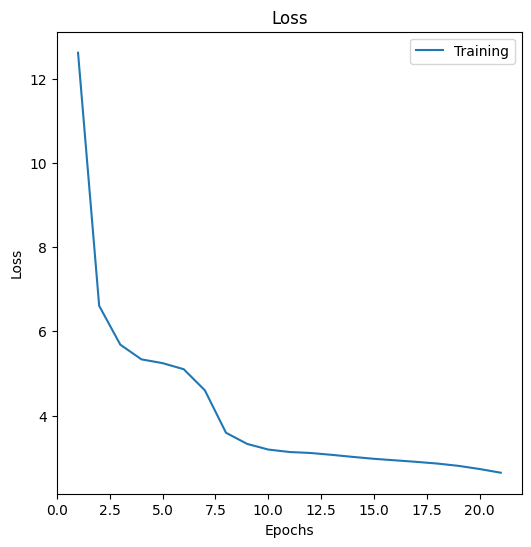

In [21]:
plot_loss(training_loss,'Training')

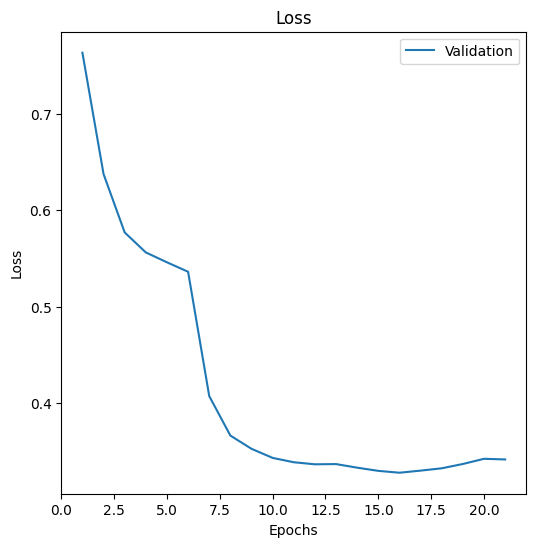

In [22]:
plot_loss(val_loss, 'Validation')

# Model Test

In [23]:
from skimage.metrics import structural_similarity as ssim
import skimage.measure

In [24]:
def print_test(outputs, predictions):
  fig, axes = plt.subplots(1, 2)
  axes[0].imshow(outputs[0].cpu().permute(1,2,0))
  axes[0].set_title('Groundthruth')
  axes[0].axis('off')
  axes[1].imshow(predictions[0].cpu().permute(1,2,0).detach().numpy())
  axes[1].set_title('Inpainted')
  axes[1].axis('off')
  #plt.title(f'Epoch {epoch}')
  plt.show()
  print("\n")
  return

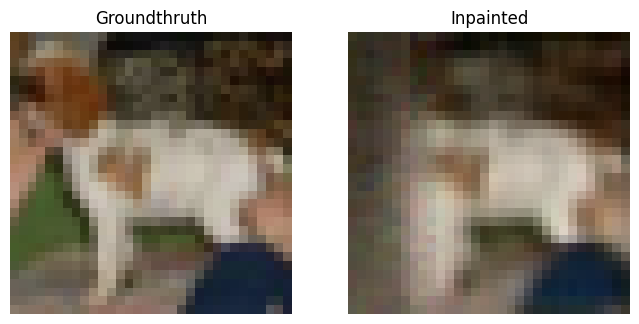

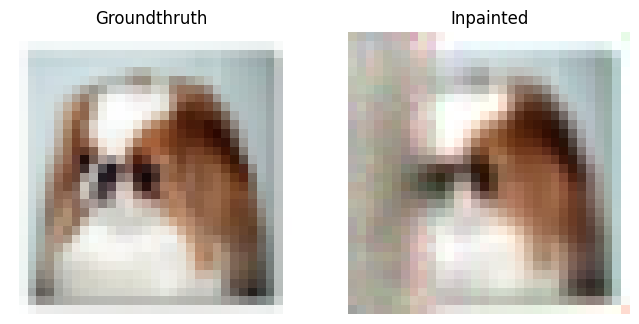

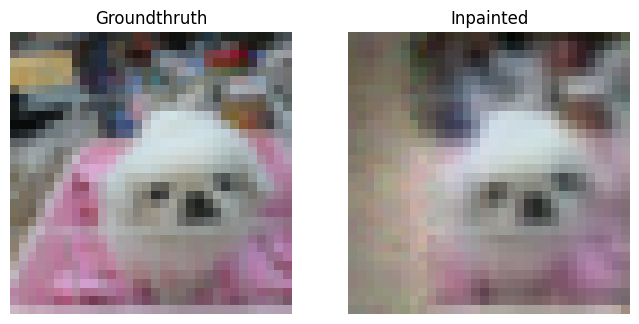

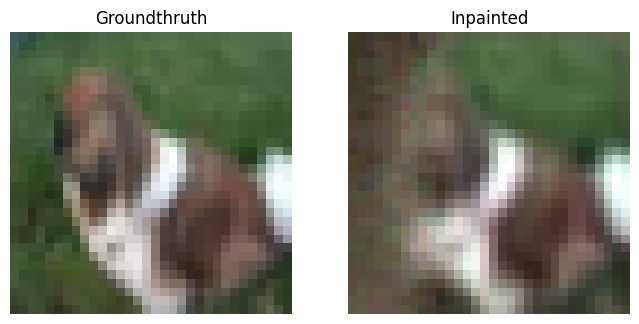

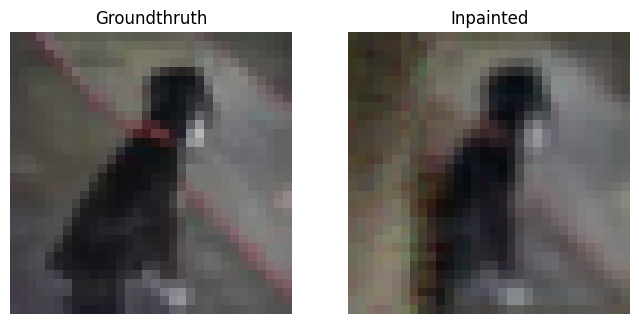

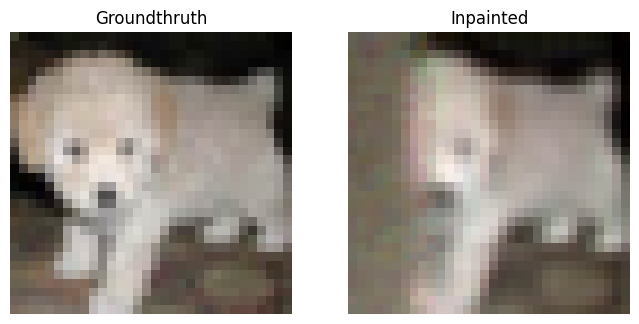

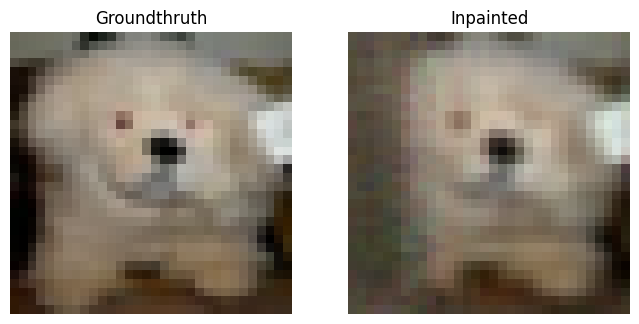

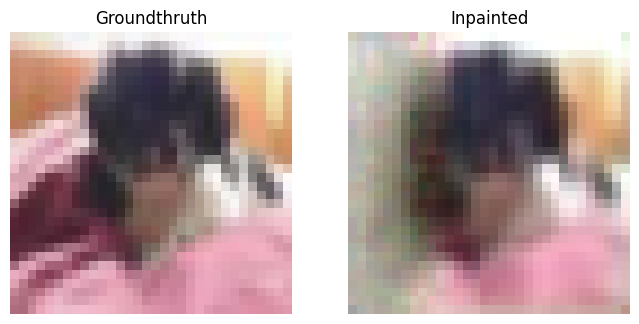

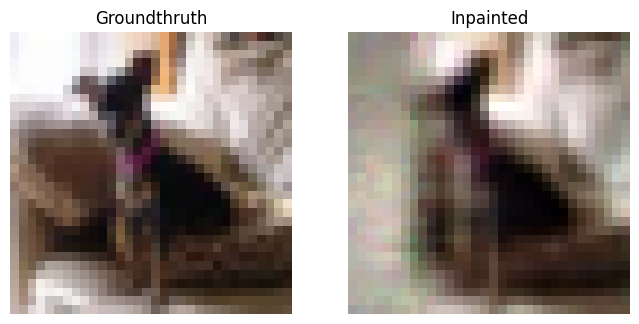

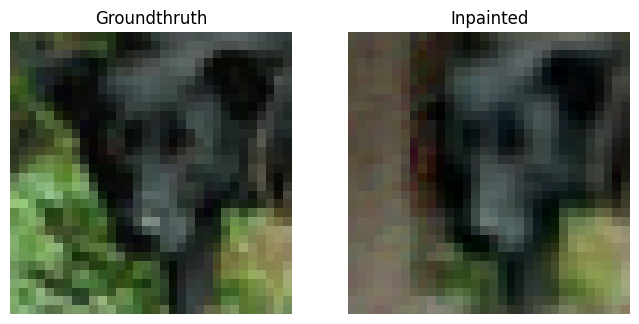

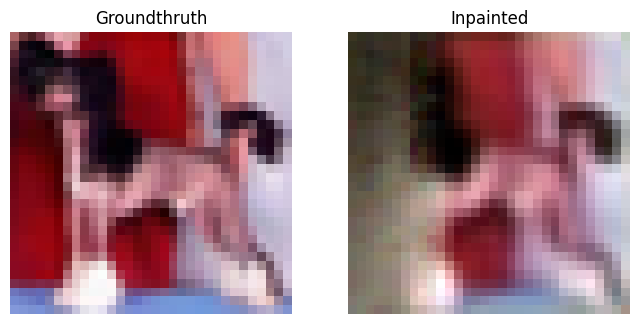

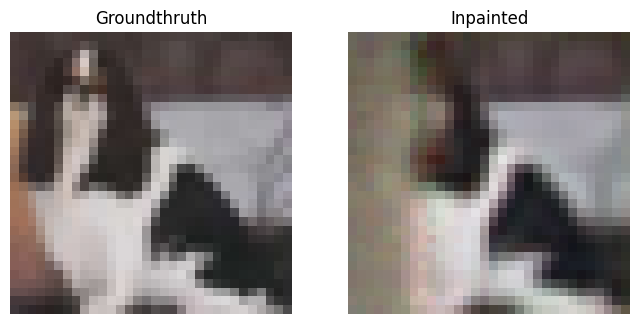

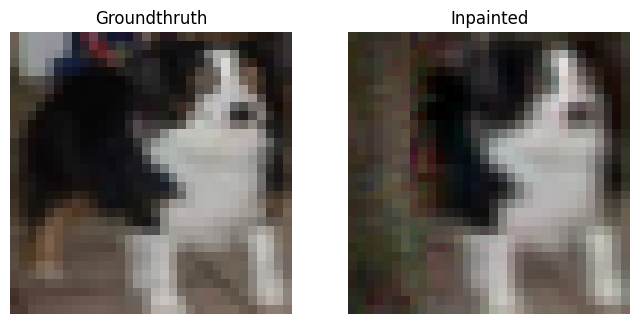

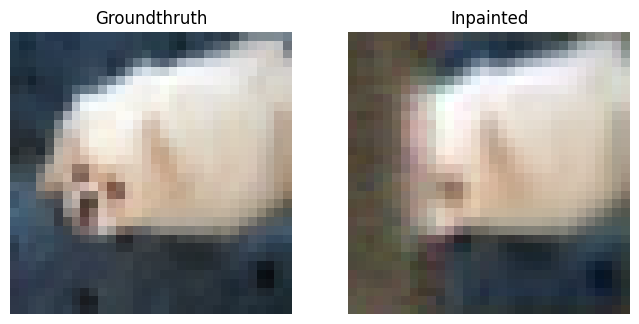

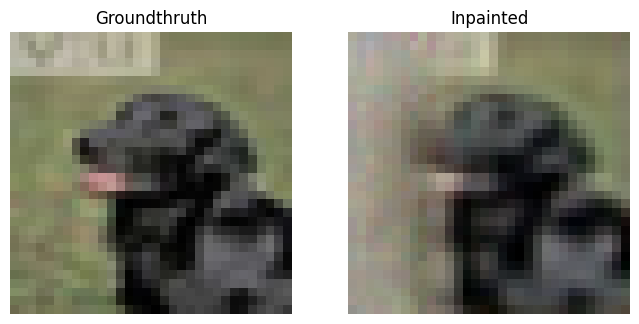

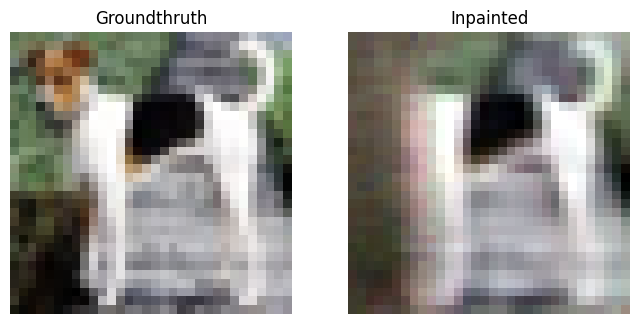

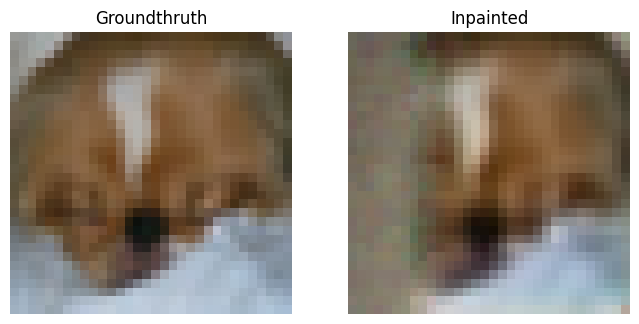

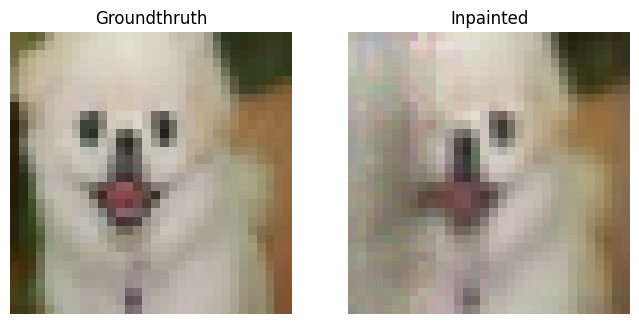

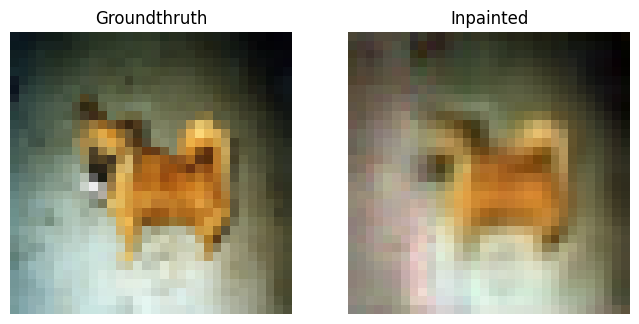

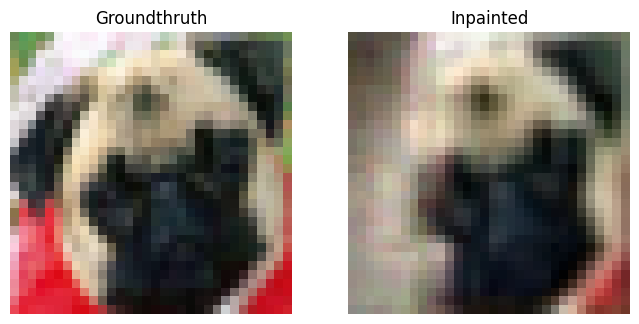

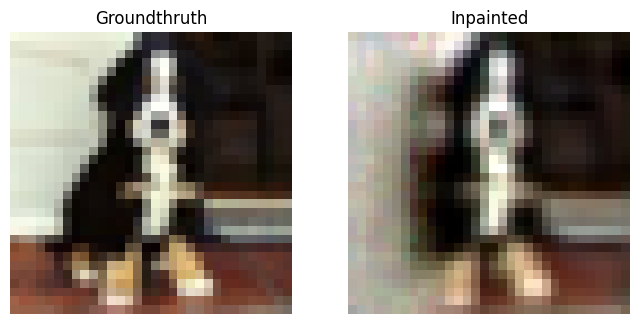

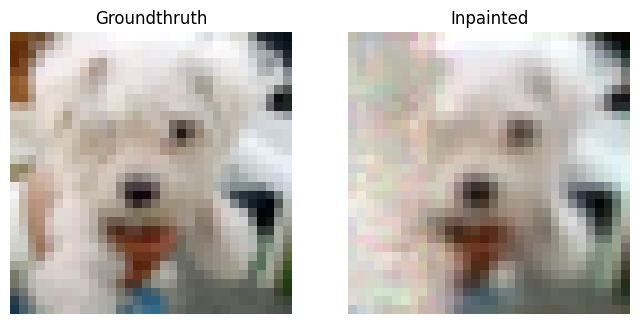

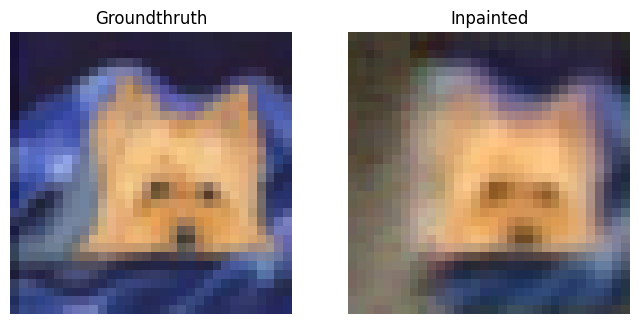

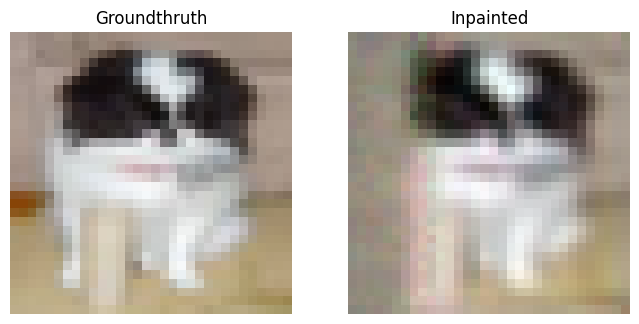

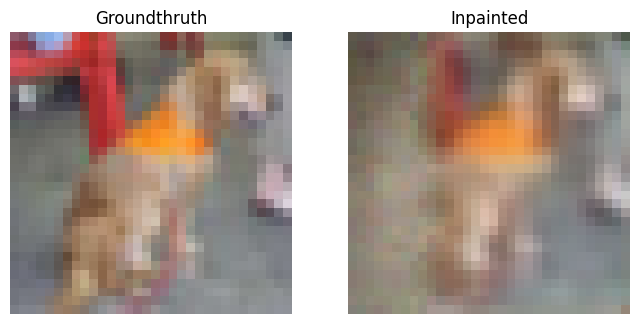

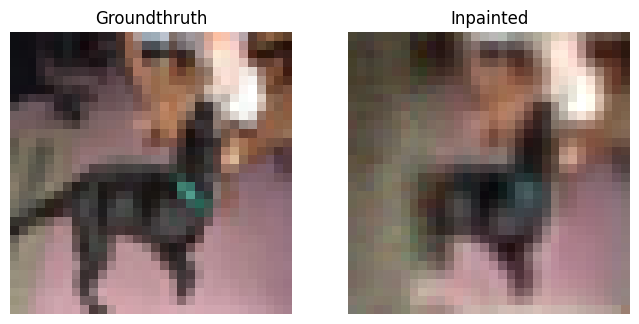

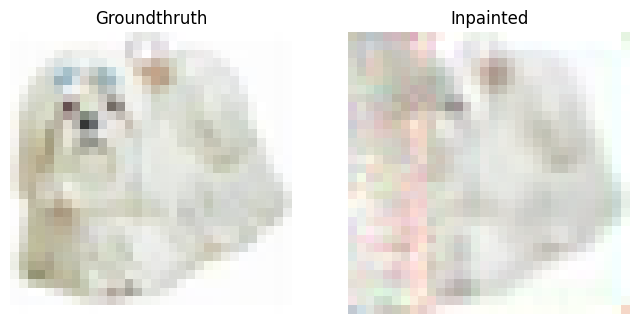

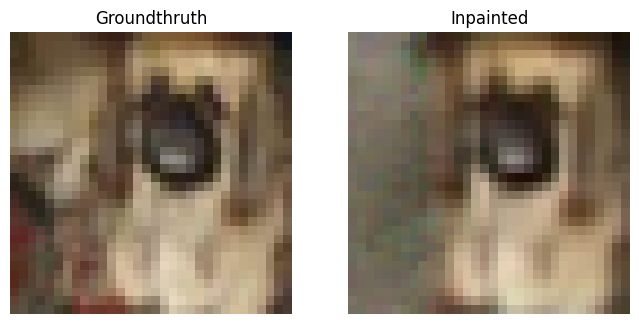

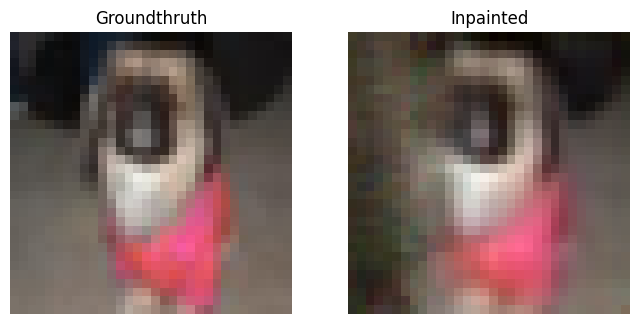

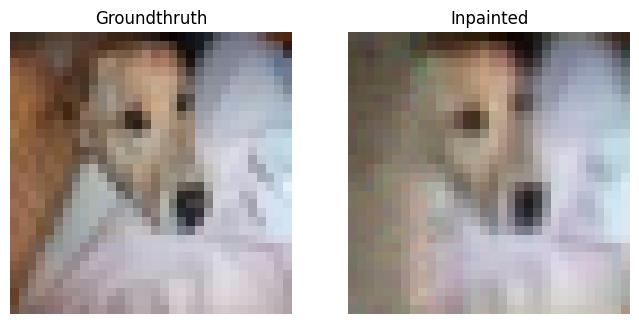

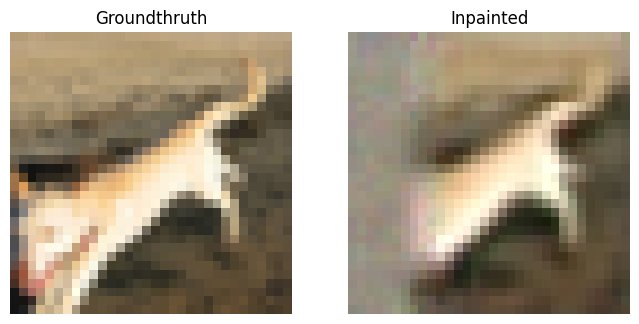

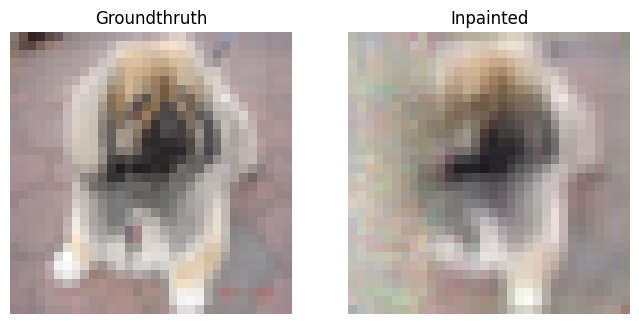

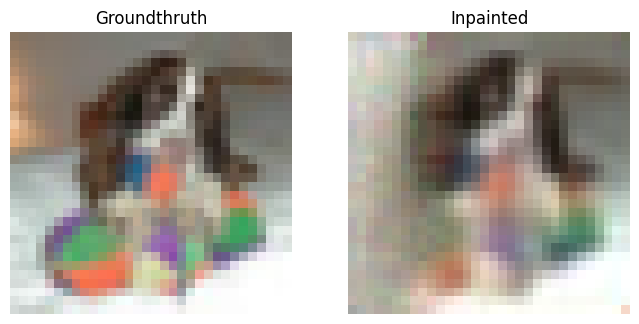

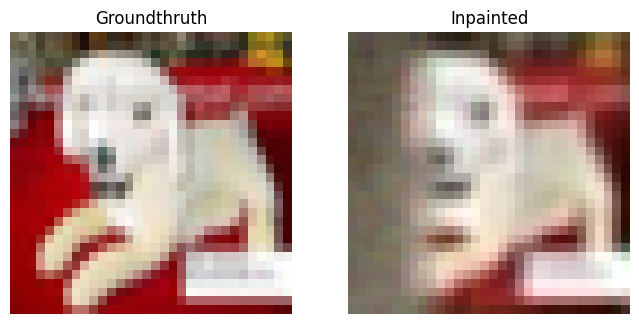

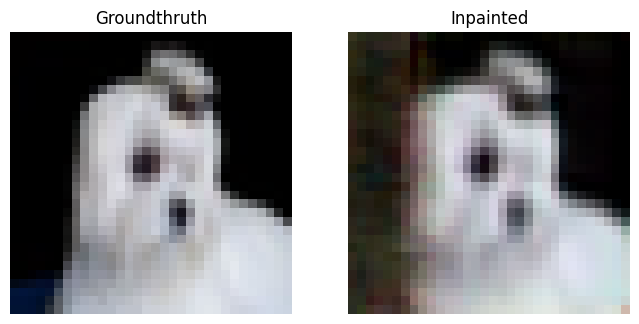

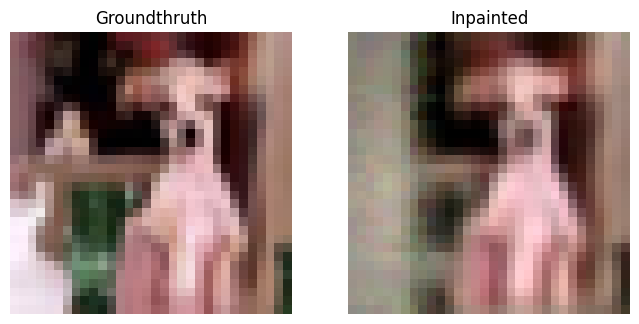

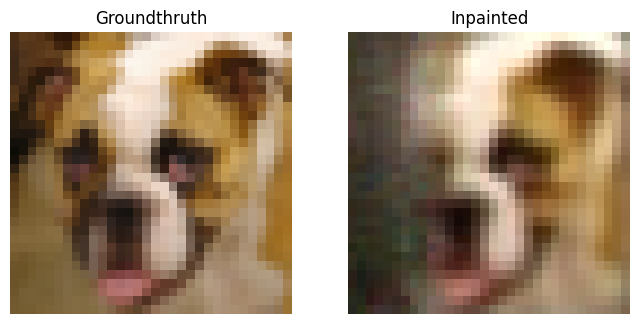

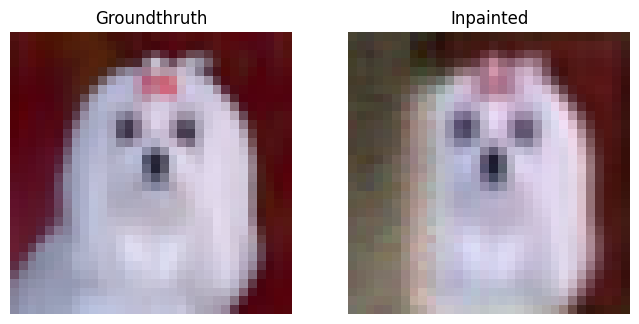

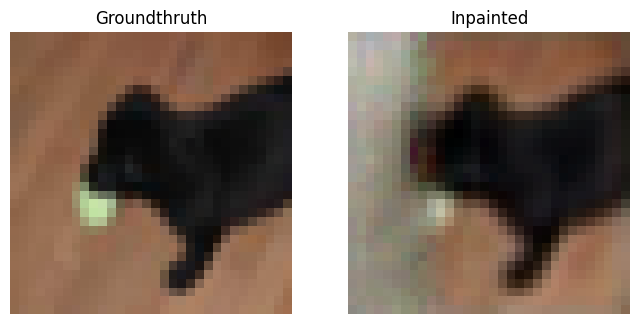

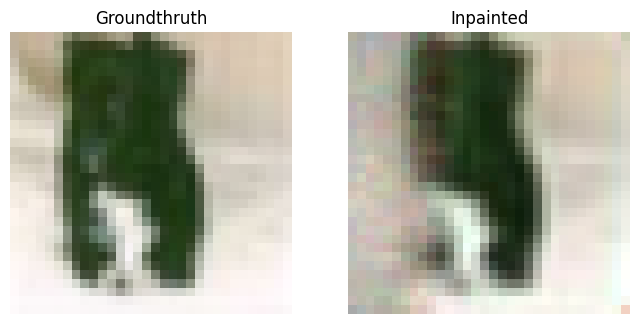

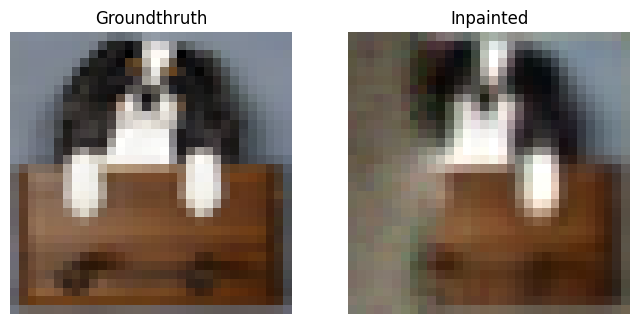

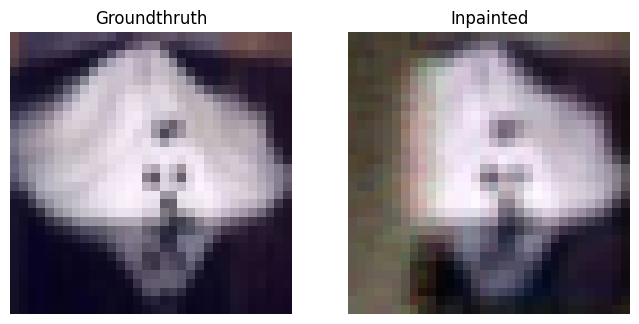

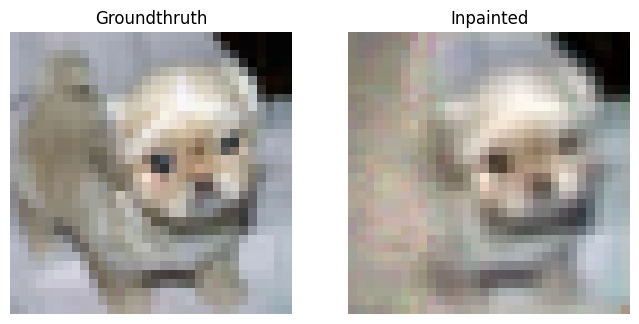

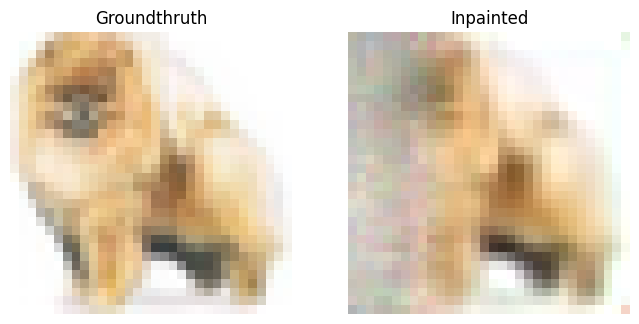

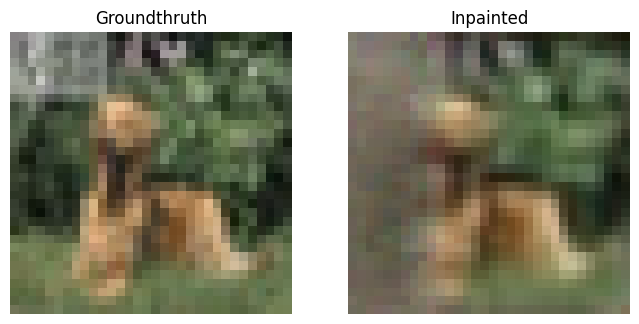

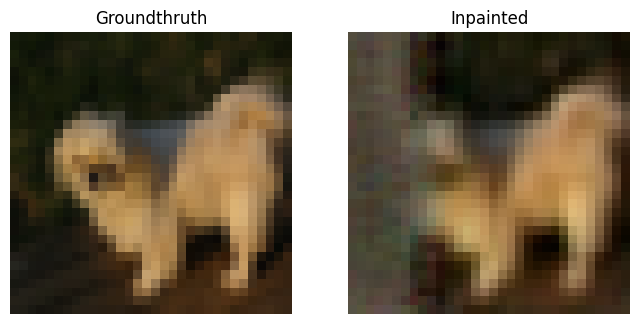

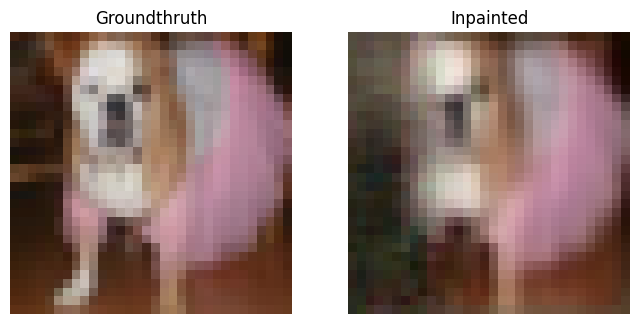

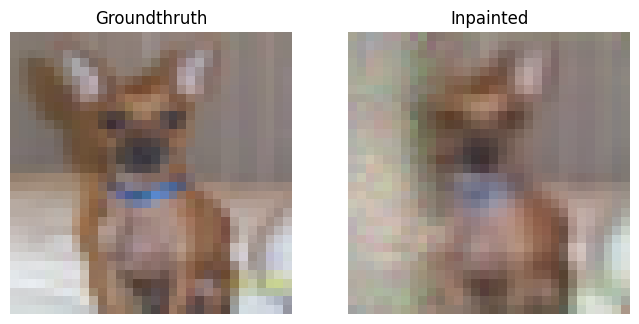

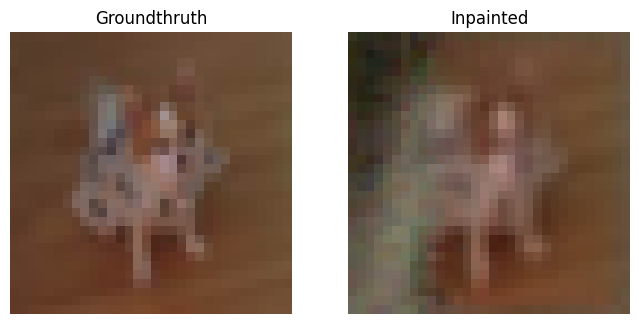

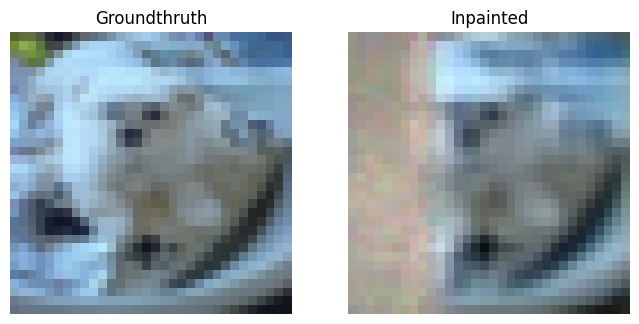

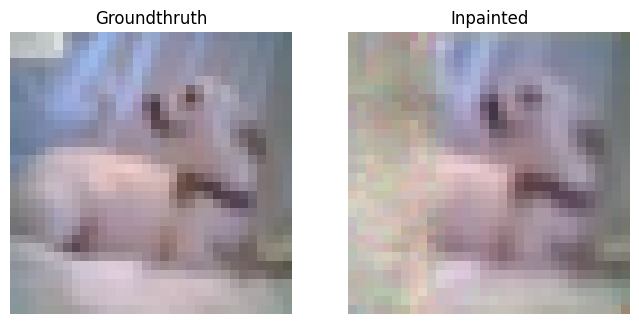

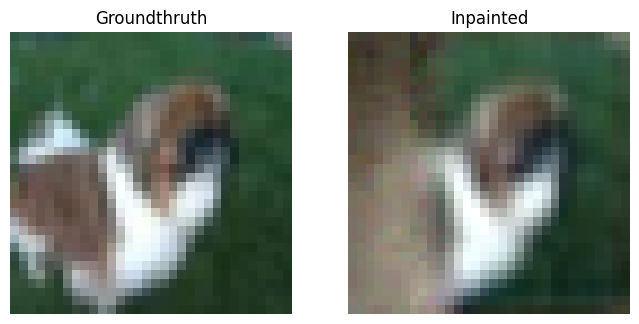

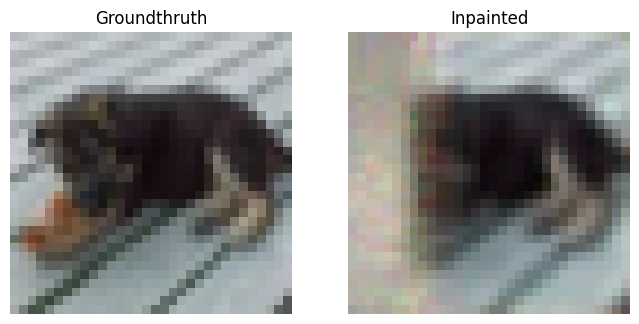

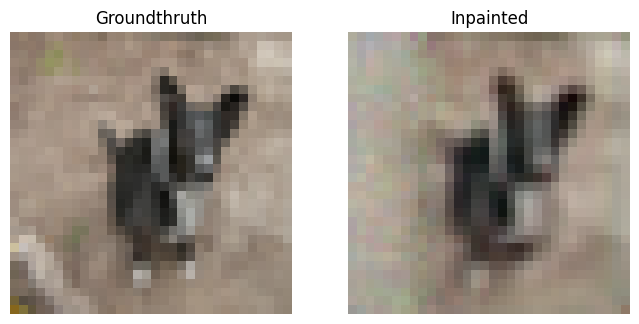

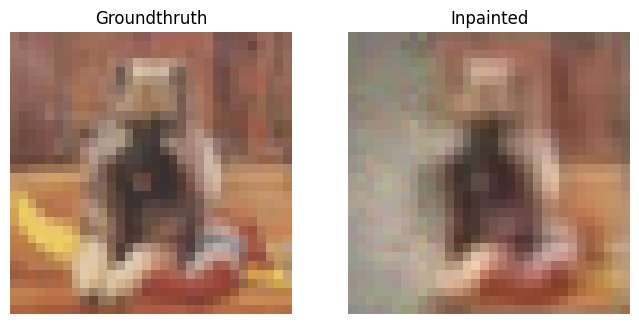

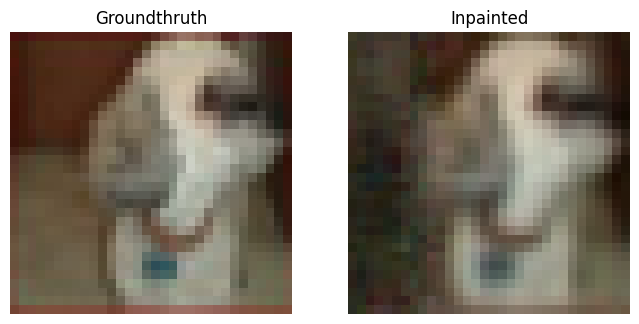

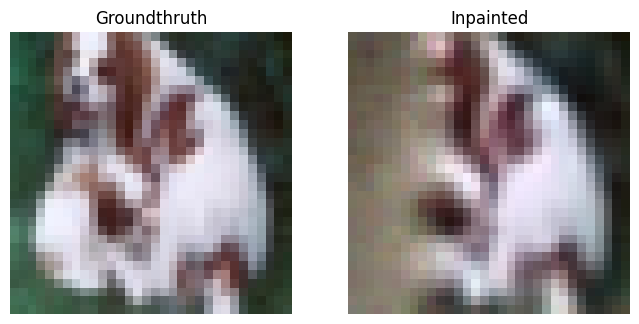

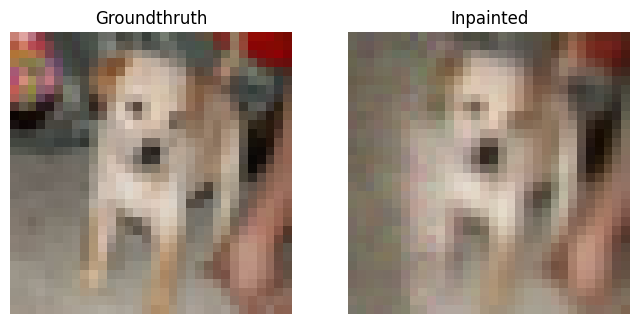

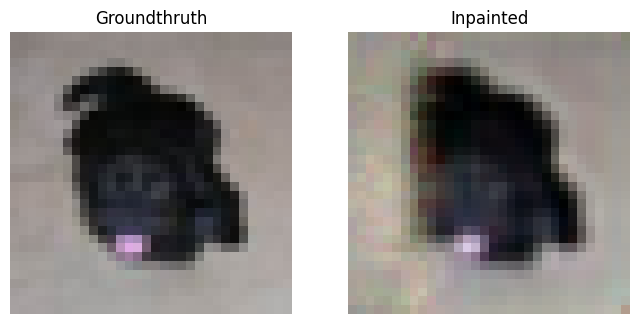

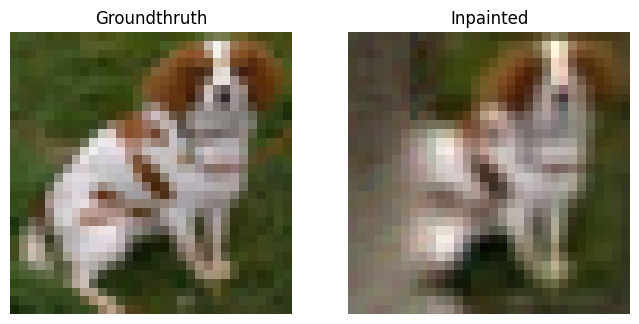

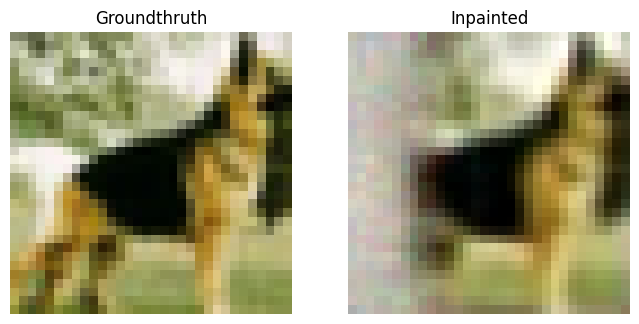

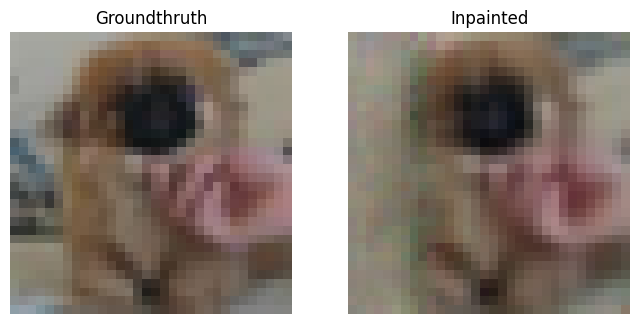



Average loss: 0.011529496780806971
Average ssim: 0.8438719900012611
Average PSNR: 19.407058167993924


In [25]:
# Model Test

SSIM = 0
PSNR = 0
test_loss = []
test_loader = DataLoader(test_dataset, batch_size = batch_size)
test_batch = test_loader.__len__()

for batch_idx, (csi, masked, outputs) in enumerate(test_loader): 
  if batch_idx < test_batch-1:
      csi_batch = csi[0].float().to('cuda')
      masked_batch = masked[0].float().to('cuda')
      outputs_batch = outputs[0].float().to('cuda')
      predictions = model(csi_batch, masked_batch)
      loss = criterion(predictions, outputs_batch)
      test_loss.append(loss.item())
      print_test(outputs_batch, predictions)
      prediction_np = predictions.cpu().detach().numpy()
      output_np = outputs_batch.cpu().detach().numpy()
      SSIM += ssim(output_np, prediction_np,  win_size=3, data_range=1.0)
      PSNR += skimage.metrics.peak_signal_noise_ratio(output_np, prediction_np, data_range=1.0)

num_images = len(test_loss)

if (num_images!=0):
    print(f"Average loss: {sum(test_loss)/num_images}")
    print(f"Average ssim: {SSIM/num_images}")
    print(f"Average PSNR: {PSNR/num_images}")
    